In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tabulate import tabulate
from helpers.util_functions import normalise_value

from moral.ppo import PPO, TrajectoryDataset, update_policy
from envs.gym_wrapper import *
import random

from quality_metrics.validity_measures import validity_all as validity
from quality_metrics.validity_measures import validity_single, validity_single_partial
from quality_metrics.distance_measures import distance_all as distance
from quality_metrics.distance_measures import distance_single
from quality_metrics.diversity_measures import diversity_all as diversity
from quality_metrics.diversity_measures import diversity_single, distance_subtrajectories
from quality_metrics.critical_state_measures import critical_state_all as critical_state
from quality_metrics.critical_state_measures import critical_state_single
from quality_metrics.realisticness_measures import realisticness_all as realisticness
from quality_metrics.realisticness_measures import realisticness_single_partial
from quality_metrics.sparsity_measure import sparsity_all as sparsity
from quality_metrics.sparsity_measure import sparsitiy_single_partial

# pearson correlation
from scipy.stats import pearsonr, spearmanr

c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_steps = 75
    base_path = '.\datasets\\100mstep\\'
    measure_statistics = True
    num_runs = 30
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'mcts' # 'mcts' or 'step'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load normalisation

with open('..\..\interpretability\\normalisation_values.pkl', 'rb') as f:
    normalisation = pkl.load(f)

weights = pkl.load(open('..\..\quality_metrics\\1000weights.pkl', 'rb'))

random.seed(4)
seed_env = random.randint(0, 100000)
torch.manual_seed(seed_env)
np.random.seed(seed_env)

# Create Environment
vec_env = VecEnv(config.env_id, config.n_workers, seed=seed_env)
states = vec_env.reset()
states_tensor = torch.tensor(states).float().to(device)

# Fetch Shapes
n_actions = vec_env.action_space.n
obs_shape = vec_env.observation_space.shape
state_shape = obs_shape[:-1]
in_channels = obs_shape[-1]

ppo = PPO(state_shape=state_shape, in_channels=in_channels, n_actions=n_actions).to(device)
ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10].pt', map_location=torch.device('cpu')))
# ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10]_new.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

# MCTS

In [13]:
ablations = []

for folder in os.listdir('..\..\datasets\\ablations_norm\mcts'):
    ablations.append(folder)
    
cfs = {}
orgs = {}
starts = {}
lengths = {}
efficiencies = {}
for ablation in ablations:
    try:
        if ablation == 'a_num_iterations10_action_threshold0.001':
            a=0
        with open('..\..\datasets\\ablations_norm\mcts\\' + ablation + '\cf_trajectories.pkl', 'rb') as f:
            cfs[ablation] = pkl.load(f)
        with open('..\..\datasets\\ablations_norm\mcts\\' + ablation + '\org_trajectories.pkl', 'rb') as f:
            orgs[ablation] = pkl.load(f)
        with open('..\..\datasets\\ablations_norm\mcts\\' + ablation + '\statistics\start_points.pkl', 'rb') as f:
            starts[ablation] = pkl.load(f)
        with open('..\..\datasets\\ablations_norm\mcts\\' + ablation + '\statistics\lengths_cf.pkl', 'rb') as f:
            lengths[ablation] = pkl.load(f)
        with open('..\..\datasets\\ablations_norm\mcts\\' + ablation + '\statistics\effiencies.pkl', 'rb') as f:
            efficiencies[ablation] = pkl.load(f)
    except:
        # delete the folder
        print(ablation)
        os.rmdir('..\..\datasets\\ablations_norm\mcts\\' + ablation)
        ablations.remove(ablation)

In [15]:
vals_all, proxs_all, divs_all, crits_all, spars_all, reals_all, qcs_all = {}, {}, {}, {}, {}, {}, {}

for ablation in ablations:
    vals, proxs, divs, crits, spars, reals, qcs = [], [], [], [], [], [], []
    prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []
    for i in range(len(orgs[ablation])):
            weight = weights[i]
            val = validity_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            val = normalise_value(val, normalisation, 'validity') * weight['validity']
            vals.append(val)
            prox = distance_subtrajectories(orgs[ablation][i][0], cfs[ablation][i][0])
            prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
            proxs.append(prox)
            div = diversity_single(orgs[ablation][i][0], cfs[ablation][i][0], starts[ablation][i], prev_org_trajs, prev_cf_trajs, prev_starts)
            div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
            divs.append(div)
            crit = critical_state_single(ppo, orgs[ablation][i][0]['states'][0])
            crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
            crits.append(crit)
            spar = sparsitiy_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
            spars.append(spar)
            real = realisticness_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
            reals.append(real)
            qc = val + prox + div + crit + spar + real
            qcs.append(qc)

            prev_org_trajs.append(orgs[ablation][i][0])
            prev_cf_trajs.append(cfs[ablation][i][0])
            prev_starts.append(starts[ablation][i])

    vals_all[ablation] = vals
    proxs_all[ablation] = proxs
    divs_all[ablation] = divs
    crits_all[ablation] = crits
    spars_all[ablation] = spars
    reals_all[ablation] = reals
    qcs_all[ablation] = qcs

In [16]:
import scipy.stats as stats
# test statstical significance

means = {}
p_values = {}
stds = {}
length = {}
start = {}
for ablation in ablations:
    # print(ablation)
    means[ablation] = np.mean(qcs_all[ablation])
    p_values[ablation] = stats.ttest_ind(qcs_all[ablation], qcs_all['a'], equal_var=False)[1]
    stds[ablation] = np.std(qcs_all[ablation])
    length[ablation] = np.mean(lengths[ablation])
    start[ablation] = np.mean(starts[ablation])
    
    
    # if ablation == 'a_num_iterations60_action_threshold0.03_likelihood_terminal0.1_discount_factor0.9':
    #     print(means[ablation], stds[ablation])

In [14]:
# Show in a table
table = [
    ['Ablation', 'Mean', 'p-value (compared to normal)', 'starts', 'lengths'],
]
for ablation in ablations:
    table.append([ablation, means[ablation], p_values[ablation], start[ablation], length[ablation]])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════════════════════════════════════════════════════════════╤═════════╤════════════════════════════════╤══════════╤═══════════╕
│ Ablation                                                                  │    Mean │   p-value (compared to normal) │   starts │   lengths │
╞═══════════════════════════════════════════════════════════════════════════╪═════════╪════════════════════════════════╪══════════╪═══════════╡
│ a                                                                         │ 1.30881 │                     1          │    19.66 │      3.37 │
├───────────────────────────────────────────────────────────────────────────┼─────────┼────────────────────────────────┼──────────┼───────────┤
│ a_branching_heuristic0                                                    │ 1.32854 │                     0.759208   │    20.7  │      3.28 │
├───────────────────────────────────────────────────────────────────────────┼─────────┼────────────────────────────────┼──────────┼─────

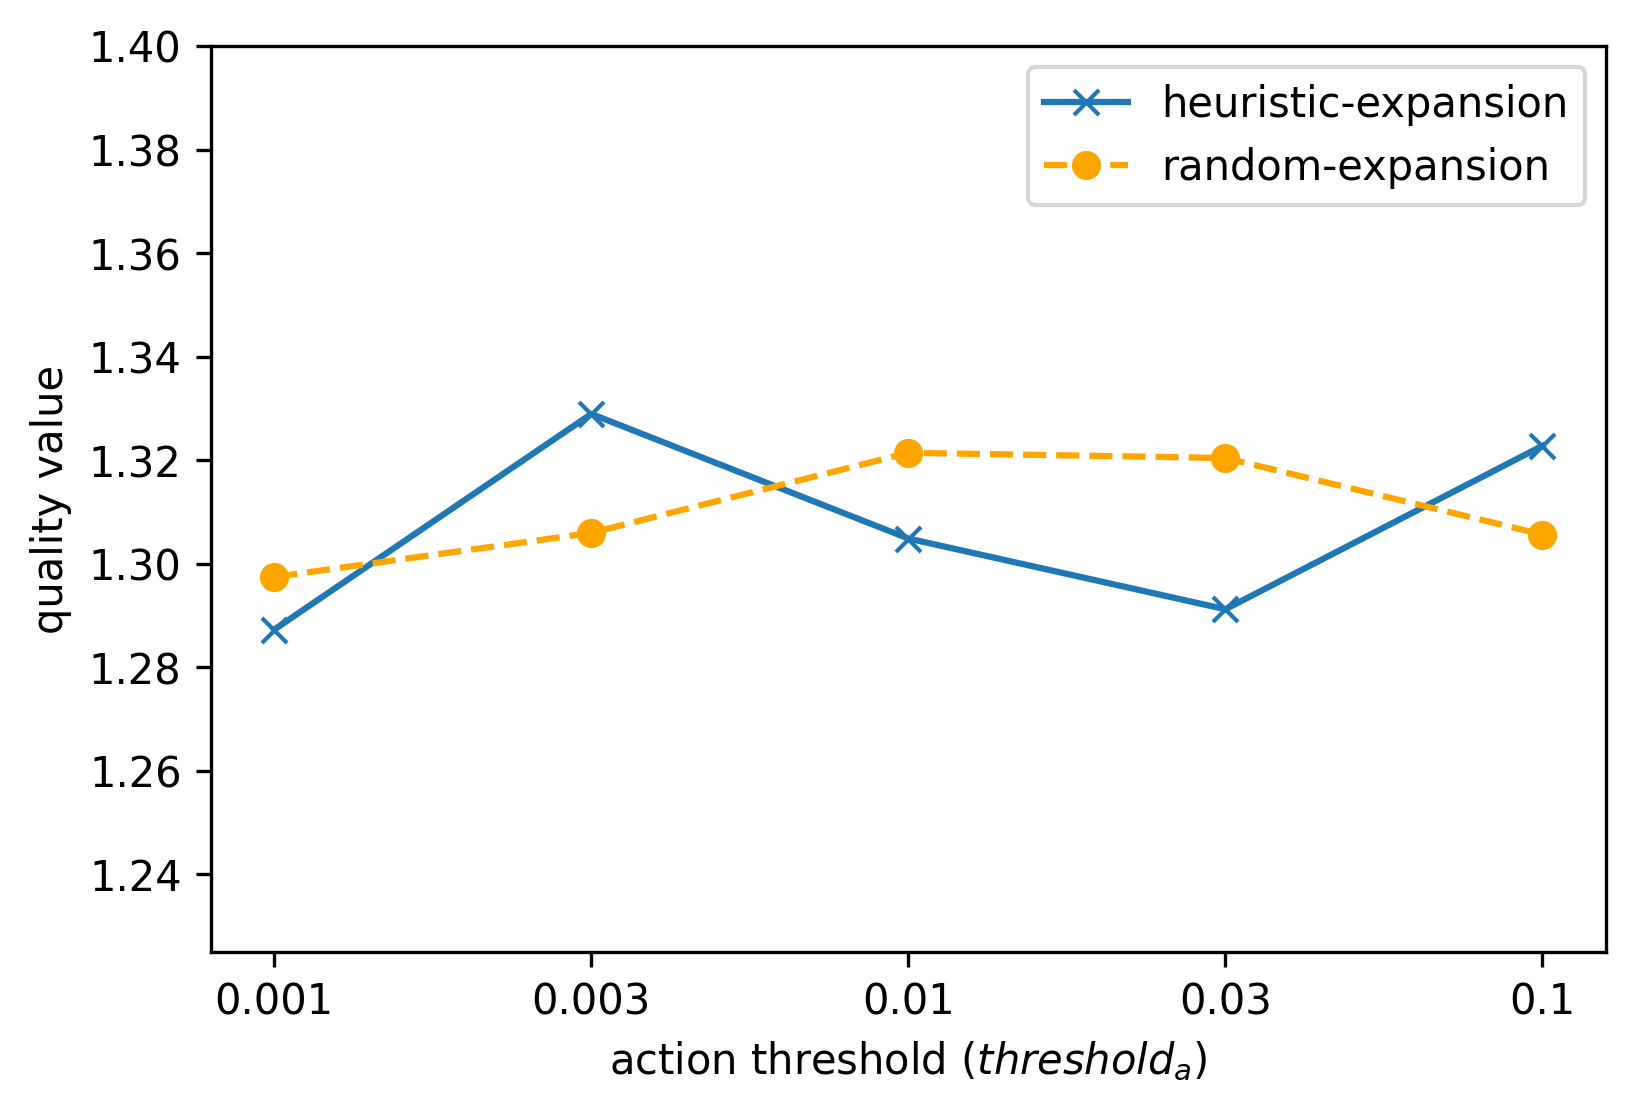

In [77]:
# show action_threshold in a graph

thresholds = [0.001, 0.003, 0.01, 0.03, 0.1]
strings1 = ['a_action_threshold'+str(i) if i!=0.003 else 'a' for i in thresholds]
strings2 = ['a_action_threshold'+str(i)+'_branching_heuristic0' if i!=0.003 else 'a_branching_heuristic0' for i in thresholds]
means_b = [means[i] for i in strings1]
means_nb = [means[i] for i in strings2]

# Create a range of indices
indices = range(len(thresholds))

# Use indices for x-coordinates in the plot
plt.figure(dpi=300)
plt.plot(indices, means_b, '-x', label='heuristic-expansion')
plt.plot(indices, means_nb, '--o', label='random-expansion', color='orange')
# numbers for the ticks in thresholds
x = list(range(len(thresholds)+1))
# plt.fill_between(x, [i-j for i,j in zip(means_threshold, stds_threshold)], [i+j for i,j in zip(means_threshold, stds_threshold)], color='b', alpha=.1)

# Use thresholds as x-tick labels
plt.xticks(indices, thresholds)

plt.xlabel('action threshold ($threshold_a$)')
plt.ylabel('quality value')
plt.legend()
plt.ylim([1.225, 1.4])
plt.show()

# go for 0.003

In [79]:
# # correlations
print(pearsonr(thresholds, means_b))
print(pearsonr(thresholds, means_nb))

print(stats.ttest_ind(qcs_all[strings1[1]], qcs_all[strings1[0]], equal_var=False)[1])
print(stats.ttest_ind(qcs_all[strings2[0]], qcs_all[strings2[2]], equal_var=False)[1])

s_n = []
for s in strings1:
    s_n.extend(qcs_all[s])

s_nb = []
for s in strings2:
    s_nb.extend(qcs_all[s])

print(np.mean(s_n), np.mean(s_nb))
print(stats.ttest_ind(s_n, s_nb, equal_var=False)[1])

PearsonRResult(statistic=0.3670011234216523, pvalue=0.5434321535984687)
PearsonRResult(statistic=-0.03444870540449757, pvalue=0.9561472227207864)
0.50014852208936
0.7054832243315754
1.3070036134014527 1.3101662782435632
0.9121763912915537


C:\Users\janwe\AppData\Local\Temp/ipykernel_21856/858023366.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(like_term, efficiencies1, 'r-', color='red', label='policy-simulation')
C:\Users\janwe\AppData\Local\Temp/ipykernel_21856/858023366.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(like_term, efficiencies2, 'r--', color='orange', label='random-simulation')


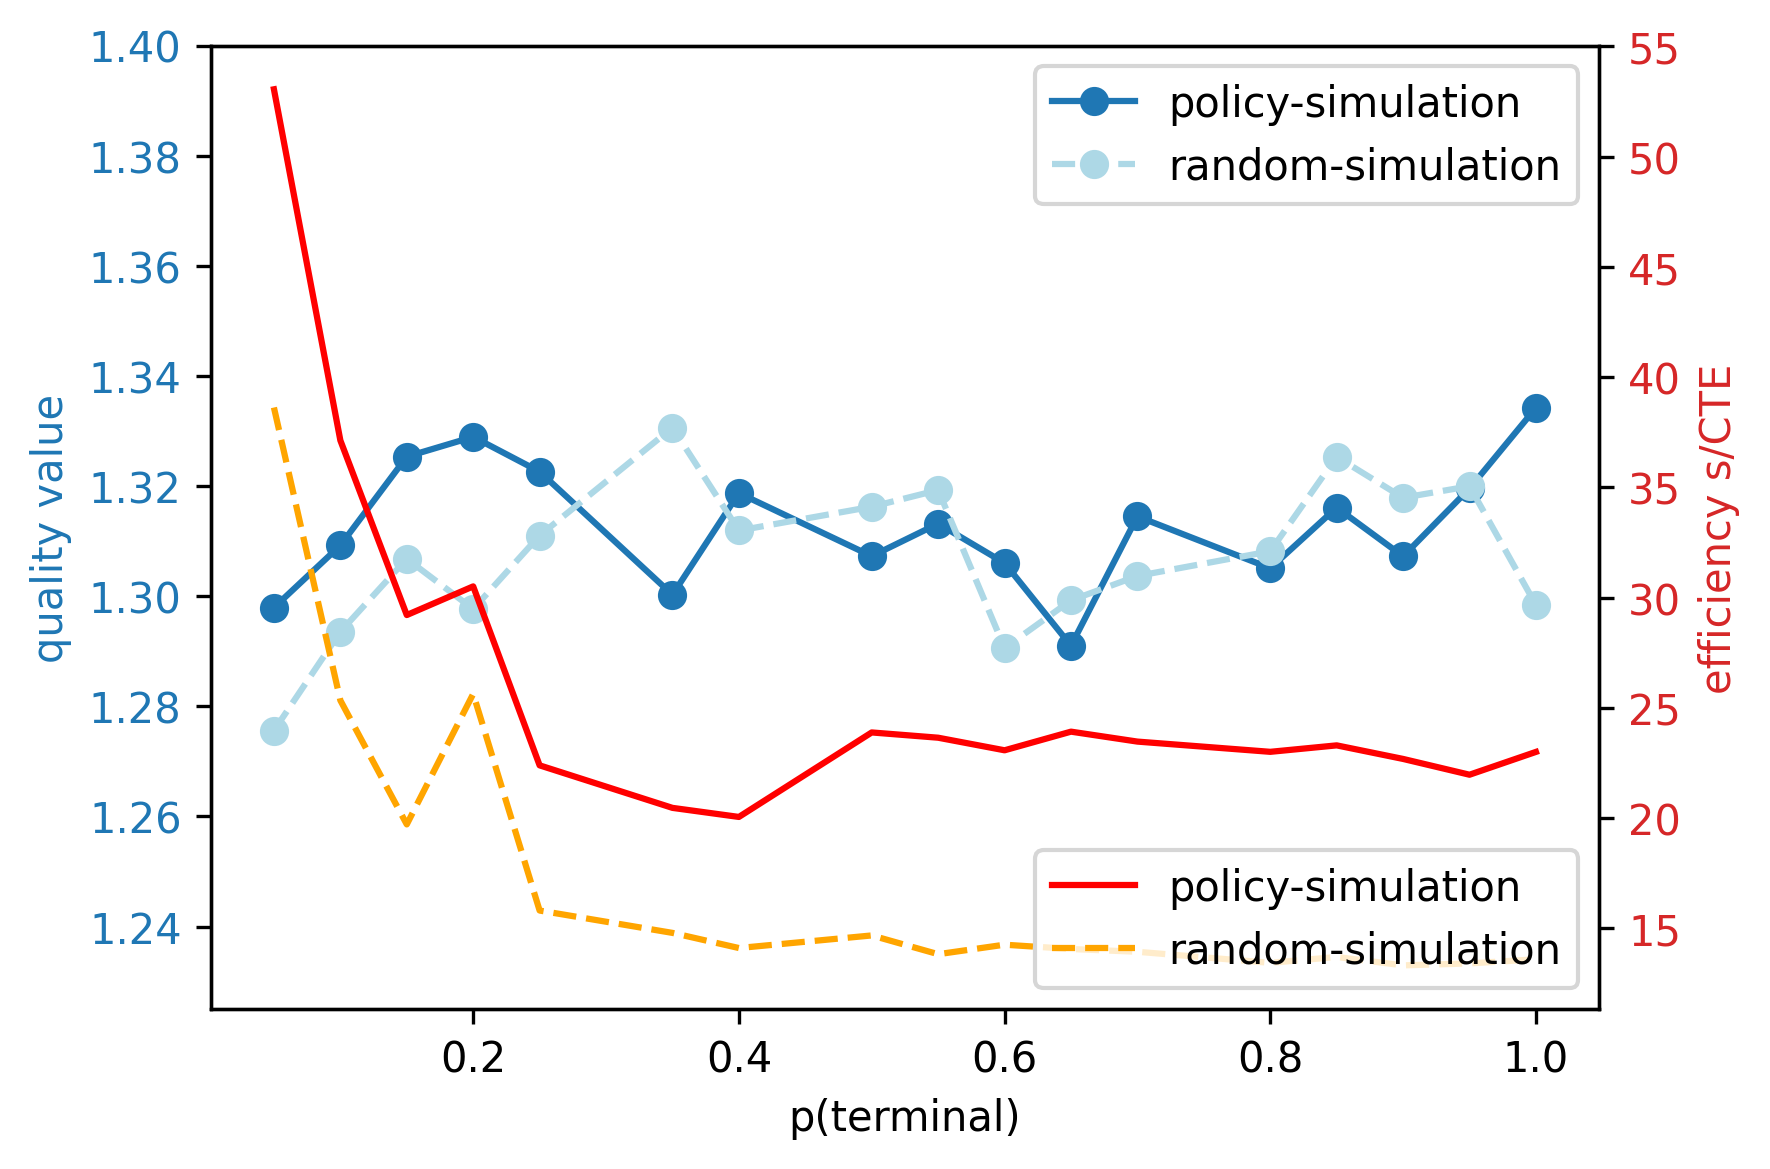

In [66]:
# show action_threshold in a graph

like_term = [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]
strings1 = ['a_likelihood_terminal'+str(i) if i!=0.2 else 'a' for i in like_term]
strings2 = ['a_likelihood_terminal'+str(i)+'_policy_simulation0' if i!=0.2 else 'a_policy_simulation0' for i in like_term]

means1 = [means[i] for i in strings1]
stds1 = [stds[i] for i in strings1]
efficiencies1 = [np.mean(efficiencies[i]) for i in strings1]
lengths1 = [np.mean(lengths[i]) for i in strings1]
means2 = [means[i] for i in strings2]
stds2 = [stds[i] for i in strings2]
efficiencies2 = [np.mean(efficiencies[i]) for i in strings2]
lengths2 = [np.mean(lengths[i]) for i in strings2]

# means_threshold = [means['a_action_threshold0.001'], means['a_action_threshold0.003'], means['a_action_threshold0.01'], means['a_action_threshold0.03'], means['a']]

# Create a range of indices
indices = range(len(like_term))

# Use indices for x-coordinates in the plot
fig, ax1 = plt.subplots(dpi=300)
plt.ylim([1.225, 1.4])
# plt.fill_between(indices, [i-j for i,j in zip(means_term, stds_term)], [i+j for i,j in zip(means_term, stds_term)], color='b', alpha=.1)

# Use thresholds as x-tick labels
# plt.xticks(indices, like_term)

color = "tab:blue"
ax1.set_xlabel('p(terminal)')
ax1.set_ylabel('quality value', color=color)
ax1.plot(like_term, means1, '-o', color=color, label='policy-simulation')
ax1.plot(like_term, means2, '--o', color='lightblue', label='random-simulation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
color = 'tab:red'
# we already handled the x-label with ax1
ax2.set_ylabel('efficiency s/CTE', color=color)
# Plot the data on the second y axis
ax2.plot(like_term, efficiencies1, 'r-', color='red', label='policy-simulation')
ax2.plot(like_term, efficiencies2, 'r--', color='orange', label='random-simulation')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

fig.tight_layout()
# plt.legend()
plt.show()

## go for 0.2

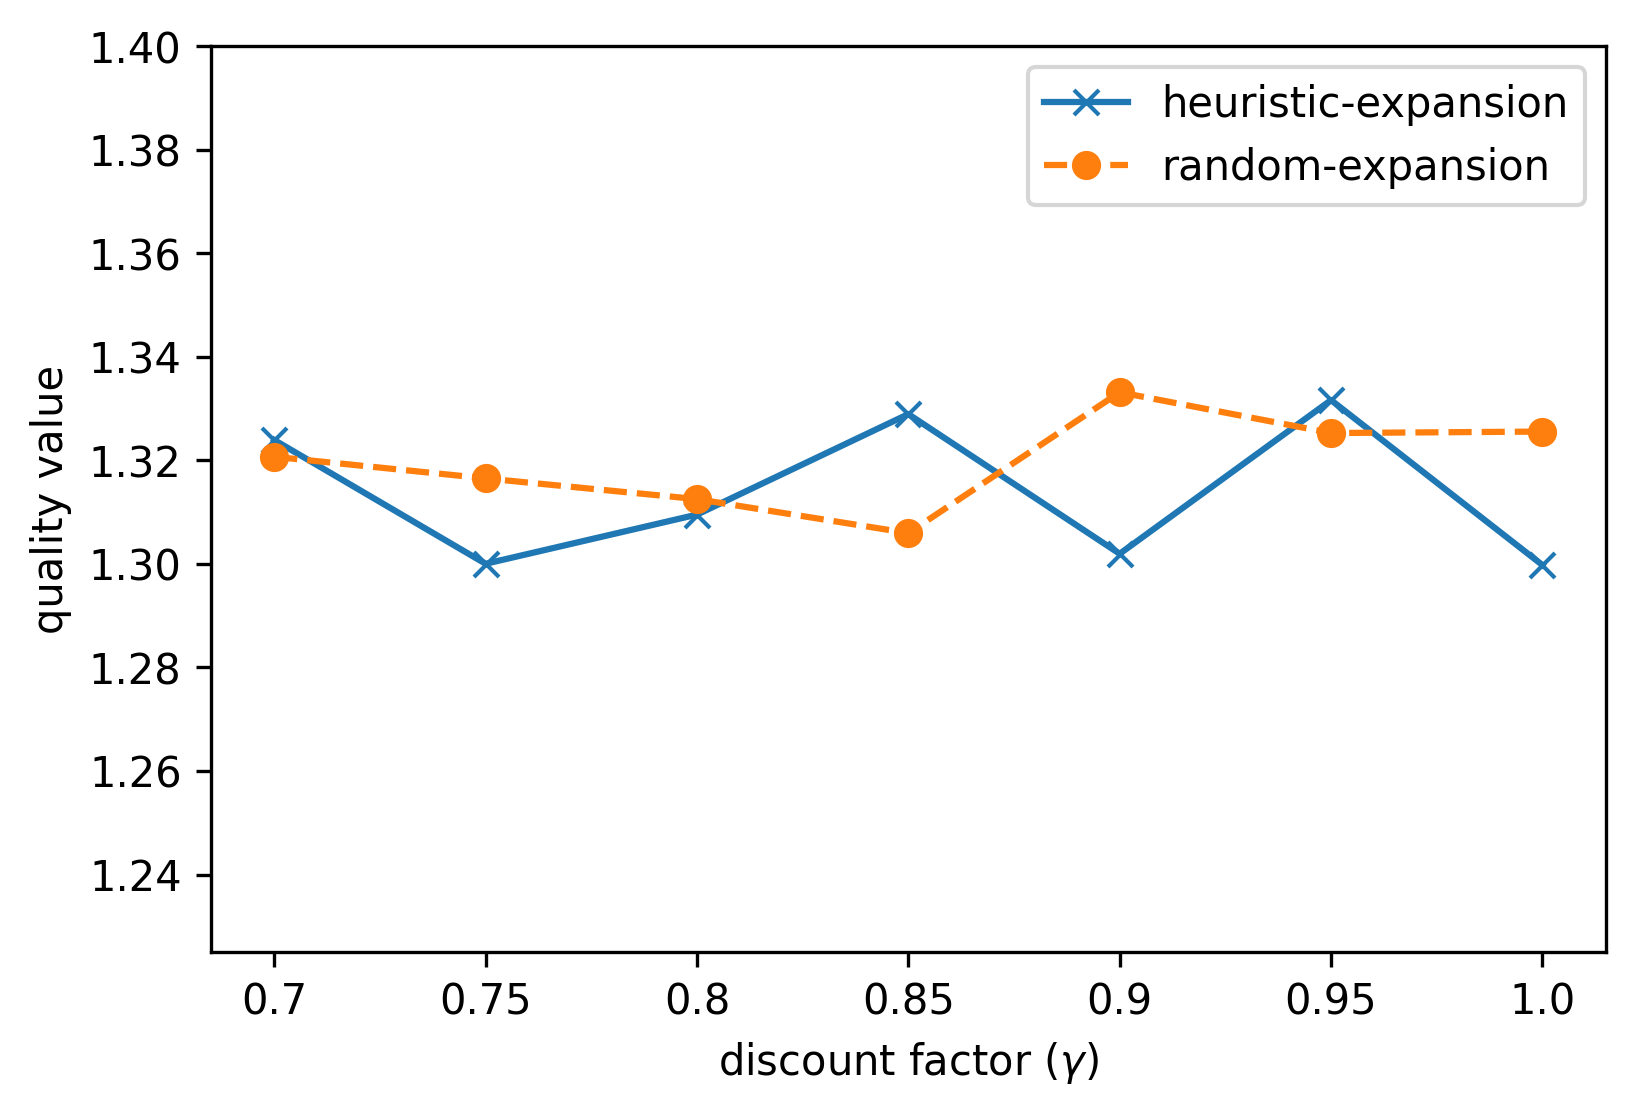

In [70]:
# plot discount_factor
discs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
strings1 = ['a_discount_factor'+str(i) if i!=0.85 else 'a' for i in discs]
strings2 = ['a_discount_factor'+str(i)+'_branching_heuristic0' if i!=0.85 else 'a_branching_heuristic0' for i in discs]
means_b = [means[i] for i in strings1]
means_nb = [means[i] for i in strings2]

indices = range(len(discs))

plt.figure(dpi=300)
plt.plot(indices, means_b, '-x', label='heuristic-expansion')
# plt.fill_between(indices, [i-j for i,j in zip(means_disc, stds_disc)], [i+j for i,j in zip(means_disc, stds_disc)], color='b', alpha=.1)

plt.plot(indices, means_nb, '--o', label='random-expansion')
# plt.fill_between(no_indices, [i-j for i,j in zip(means_disc_no, stds_disc_no)], [i+j for i,j in zip(means_disc_no, stds_disc_no)], color='r', alpha=.1)

plt.xticks(indices, discs) # this will set the x-axis labels
plt.xlabel('discount factor ($\gamma$)')
plt.ylabel('quality value')
plt.legend()
plt.ylim([1.225, 1.4])
plt.show()

## use 0.85

In [75]:
# # correlations
print(pearsonr(discs, means_b))
print(pearsonr(discs, means_nb))

s_p = []
for s in strings1:
    s_p.extend(qcs_all[s])

s_r = []
for s in strings2:
    s_r.extend(qcs_all[s])

print(np.mean(s_p), np.mean(s_r))
print(stats.ttest_ind(s_p, s_r, equal_var=False)[1])


s_pp = []
for s in strings1:
    s_pp.append(qcs_all[s])
s_rr = []
for s in strings2:
    s_rr.append(qcs_all[s])
s_rr = np.array(s_rr)
s_pp = np.array(s_pp)

corr_pp = []
corr_rr = []
for i in range(s_pp.shape[1]):
    corr_pp.append(pearsonr(discs, s_pp[:,i])[0])
    corr_rr.append(pearsonr(discs, s_rr[:,i])[0])

print(np.mean(corr_pp[1:]), np.mean(corr_rr))


PearsonRResult(statistic=-0.09186788343419774, pvalue=0.8446975306569083)
PearsonRResult(statistic=0.44696080506911595, pvalue=0.31467977773262684)
1.3136802296162997 1.31994696981562
0.7931619640213959
0.012704649076080704 0.011245760503295218


c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


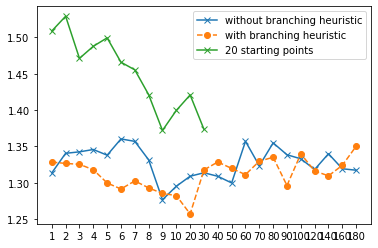

In [73]:
## num_iterations

iters = [1,2,3,4,5,6,7,8,9,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120,140,160, 180]
iters_s = [1,2,3,4,5,6,7,8,9,10, 20, 30]

str1 = 'a_num_iterations'
str2 = '_branching_heuristic0'
strings1 = [str1+str(i) if i!=40 else 'a' for i in iters]
strings2 = [str1+str(i)+str2 if i!=40 else 'a'+str2 for i in iters]
strings3 = [str1+str(i)+'_starting_points20' if i!=40 else 'a_starting_points20' for i in iters]

means1 = [means[str1+str(i)] if i!=40 else means['a'] for i in iters]
stds_iter = [stds[str1+str(i)] if i!=40 else stds['a'] for i in iters]

means2 = [means[str1+str(i)+str2] if i!=40 else means['a'+str2] for i in iters]
stds_iter2 = [stds[str1+str(i)+str2] if i!=40 else stds['a'+str2] for i in iters]

means3 = [means[str1+str(i)+'_starting_points20'] if i!=40 else means['a_starting_points20'] for i in iters_s]
stds_iter3 = [stds[str1+str(i)+'_starting_points20'] if i!=40 else stds['a_starting_points20'] for i in iters_s]

indices = range(len(iters))
indices_s = range(len(iters_s))
plt.plot(indices, means1, '-x', label='without branching heuristic')
plt.plot(indices, means2, '--o', label='with branching heuristic')
plt.plot(indices_s, means3, '-x', label='20 starting points')
# plt.plot(indices_b, means_iter_b, '--o')
# plt.fill_between(indices, [i-j for i,j in zip(means_iter, stds_iter)], [i+j for i,j in zip(means_iter, stds_iter)], color='b', alpha=.1)

plt.xticks(indices, iters)
plt.legend()
plt.show()

# go for 40

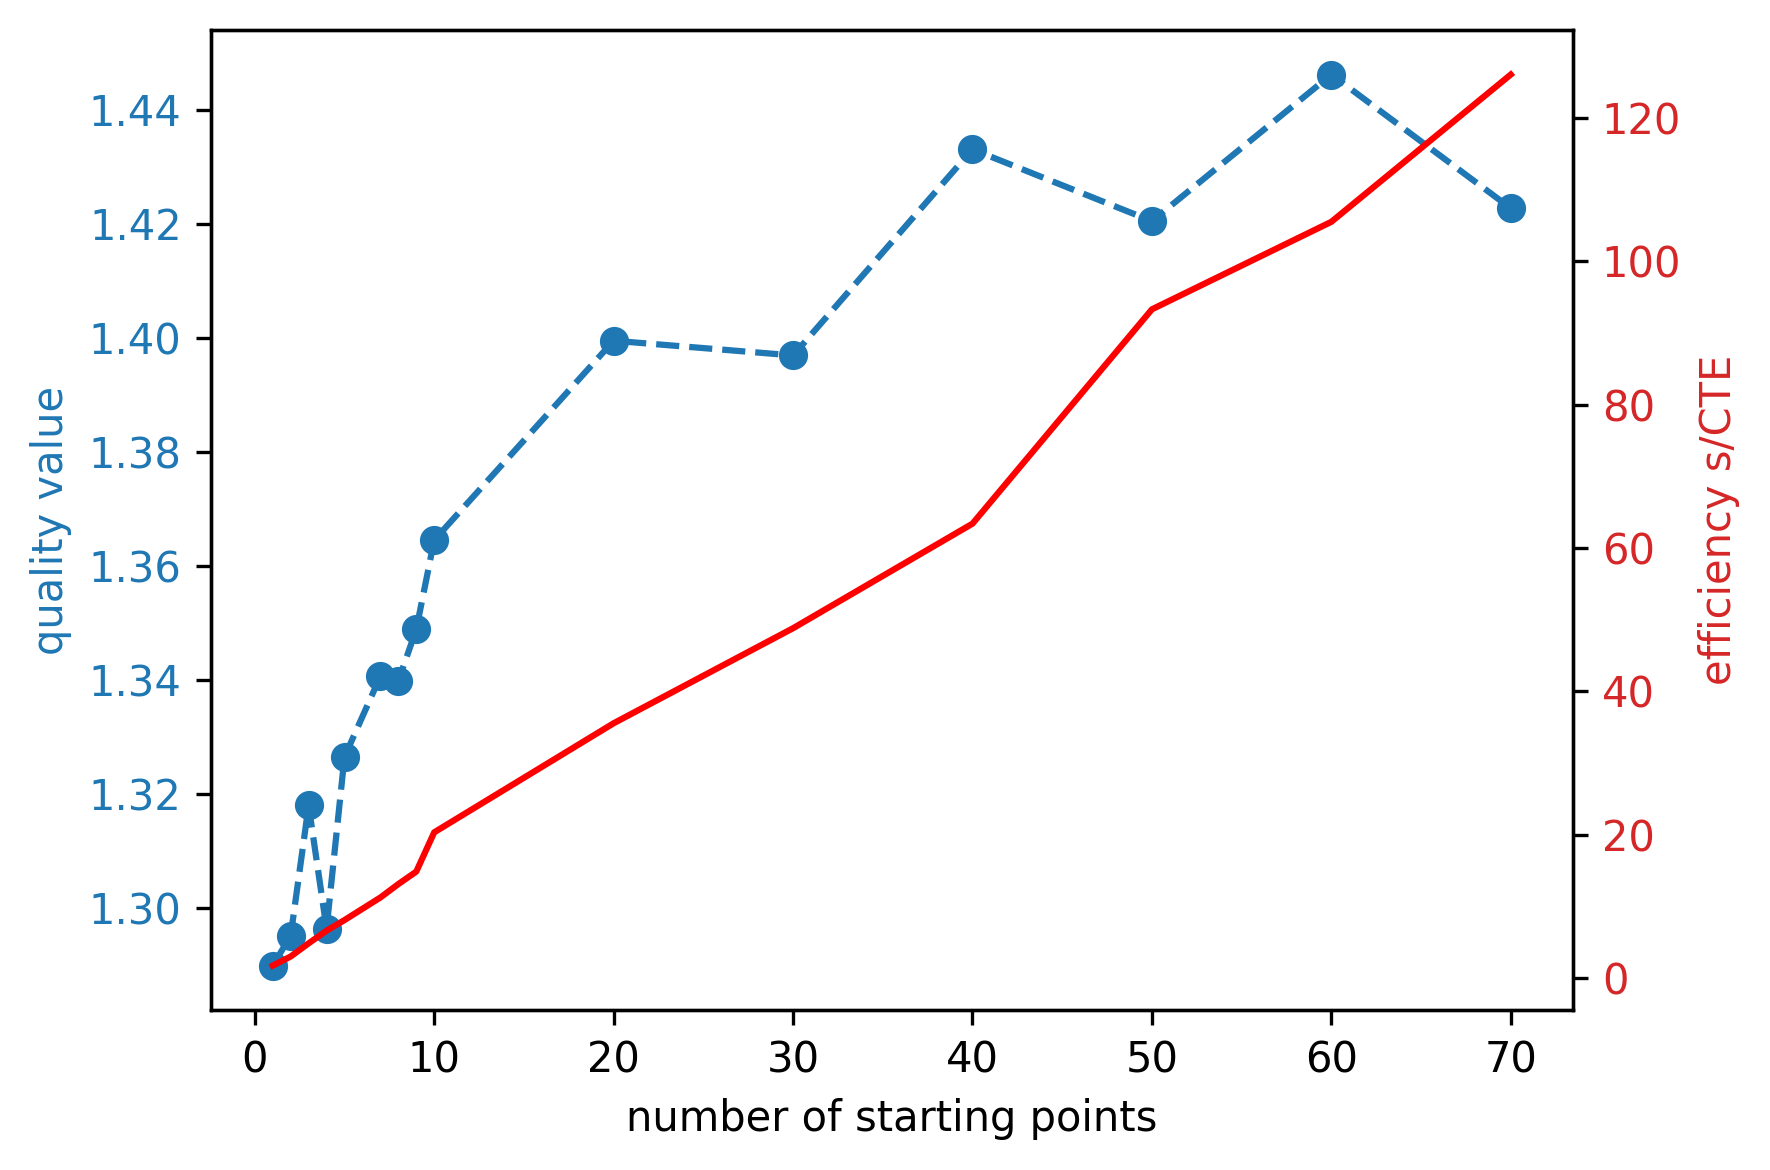

In [66]:
# starts
starts = [1,2,3,4,5,7,8,9,10,20,30,40,50,60,70]
str1 = 'a_num_iterations10_starting_points'
strings = [str1+str(i) if i!= 2 else 'a_num_iterations10' for i in starts]
means_starts = [means[s] for s in strings]
stds_starts = [stds[s] for s in strings]
starts_upper_quartile = [np.quantile(qcs_all[s], 0.75) for s in strings]
starts_lower_quartile = [np.quantile(qcs_all[s], 0.25) for s in strings]
efficency = [np.mean(efficiencies[s]) for s in strings]

indices = range(len(starts))
fig, ax1 = plt.subplots(dpi=300)

color = "tab:blue"
ax1.set_xlabel('number of starting points')
ax1.set_ylabel('quality value', color=color)
ax1.plot(starts, means_starts, '--o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
# we already handled the x-label with ax1
ax2.set_ylabel('efficiency s/CTE', color=color)
# Plot the data on the second y axis
ax2.plot(starts, efficency, 'r-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# go for 2

In [69]:
n_starts1 = qcs_all[str1+'1']
n_starts2 = qcs_all[str1+'60']
# measure significance
print(stats.ttest_ind(n_starts1, n_starts2, equal_var=False)[1])

0.020605517895801496


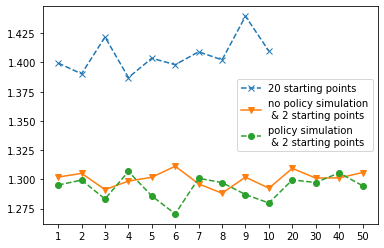

In [50]:
# sumulations
sims = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
sims2 = [1,2,3,4,5,6,7,8,9,10]
str1 = 'a_num_iterations10_num_simulations'
str2 = 'a_num_iterations10_policy_simulation0_num_simulations'
str3 = 'a_num_iterations10_starting_points20_num_simulations'

means_sims = [means[str1+str(i)] if i!= 1 else means['a_num_iterations10'] for i in sims]
stds_sims = [stds[str1+str(i)] if i!= 1 else means['a_num_iterations10'] for i in sims]

means_sims2 = [means[str2+str(i)] if i!= 1 else means['a_num_iterations10_policy_simulation0'] for i in sims]
stds_sims2 = [stds[str2+str(i)] if i!= 1 else means['a_num_iterations10_policy_simulation0'] for i in sims]

means_sims3 = [means[str3+str(i)] if i!=1 else means['a_num_iterations10_starting_points20'] for i in sims2]
stds_sims3 = [stds[str3+str(i)] if i!=1 else means['a_num_iterations10_starting_points20'] for i in sims2]

indices = range(len(sims))
indices2 = range(len(sims2))
plt.plot(indices2, means_sims3, '--x', label='20 starting points')
plt.plot(indices, means_sims2, '-v', label='no policy simulation\n & 2 starting points')
plt.plot(indices, means_sims, '--o', label='policy simulation\n & 2 starting points')
# indices2 = range(len(sims2))

plt.xticks(indices, sims)
plt.legend()
plt.show()

In [26]:
str_base = 'a_num_iterations60_action_threshold0.03_likelihood_terminal0.15_discount_factor0.9'

table = [
    ['', 'branching_heuristic', 'no branching_heuristic'],
    ['follow_policy', means[str_base], means[str_base+'_branching_heuristic0']],
    ['no follow_policy', means[str_base+'_policy_simulation0'], means[str_base+'_branching_heuristic0_policy_simulation0']]
]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤═══════════════════════╤══════════════════════════╕
│                  │   branching_heuristic │   no branching_heuristic │
╞══════════════════╪═══════════════════════╪══════════════════════════╡
│ follow_policy    │               1.29777 │                  1.30216 │
├──────────────────┼───────────────────────┼──────────────────────────┤
│ no follow_policy │               1.30963 │                  1.3129  │
╘══════════════════╧═══════════════════════╧══════════════════════════╛


### Interpretation

Increasing the action threshold is good (while decreasing doesn't make a difference)

Adding a discount rate does help (0.8 is better)

The expansion heuristic does not really help

Randomly simulating instead of choosing from a policy probably works somewhat better? (this is surprising)

Having more starts is better and fewer is worse

Increasing the likelihood of a terminal state is probably good, while decreasing it is defenitely bad.

Giving it more time (6 instead of 3 seconds) probably works a bit better, but less time (1 instaed of 3 seconds) is defenitely bad.


# Comparison to random

In [28]:
with open('..\..\datasets\\1000random\\1000\cf_trajectories.pkl', 'rb') as f:
    random_cf = pkl.load(f)
with open('..\..\datasets\\1000random\\1000\org_trajectories.pkl', 'rb') as f:
    random_org = pkl.load(f)
with open('..\..\datasets\\1000random\\1000\statistics\start_points.pkl', 'rb') as f:
    random_starts = pkl.load(f)

In [32]:
vals_random, proxs_random, divs_random, crits_random, spars_random, reals_random, qcs_random = [], [], [], [], [], [], []

for i in range(len(random_org)):
        weight = weights[i]
        val = validity_single_partial(random_org[i][0], random_cf[i][0])
        val = normalise_value(val, normalisation, 'validity') * weight['validity']
        vals_random.append(val)
        prox = distance_subtrajectories(random_org[i][0], random_cf[i][0])
        prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
        proxs_random.append(prox)
        div = diversity_single(random_org[i][0], random_cf[i][0], random_starts[i], prev_org_trajs, prev_cf_trajs, prev_starts)
        div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
        divs_random.append(div)
        crit = critical_state_single(ppo, random_org[i][0]['states'][0])
        crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
        crits_random.append(crit)
        spar = sparsitiy_single_partial(random_org[i][0], random_cf[i][0])
        spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
        spars_random.append(spar)
        real = realisticness_single_partial(random_org[i][0], random_cf[i][0])
        real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
        reals_random.append(real)
        qc = val + prox + div + crit + spar + real
        qcs_random.append(qc)

        prev_org_trajs.append(random_org[i][0])
        prev_cf_trajs.append(random_cf[i][0])
        prev_starts.append(random_starts[i])

In [33]:
print(np.mean(qcs_random))

1.0608791588289264
